# ProtVI

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

import data_support as sup
from protvi.models import PROTVI
import protvi.plots as pl
import protvi.utils as utils
import protvi.metrics as metrics
import protvi.simulations as sm
from protvi.benchmark_models import run_protDP

import scvi

np.random.seed(0)
torch.manual_seed(0)
scvi.settings.seed = 0

Global seed set to 0


Let"s load the data.

In [4]:
adata = sc.read_h5ad("../../data/processed/manns_inhouse.h5ad")

##  Mask-and-impute experiments

In [5]:
# mnar_proportion: 0, 0.25, 0.5, 0.75, 1 
mnar_proportion = 0

m_mnar, m_mcar = sm.create_mnar_mcar_mask(mv_rate=0.02, mnar_proportion=mnar_proportion, x=adata.layers["main"], seed=42)

In [6]:
print(f"MNAR: {np.sum(m_mnar) / m_mnar.size:.3f}, MCAR: {np.sum(m_mcar) / m_mcar.size:.3f}")

MNAR: 0.002, MCAR: 0.020


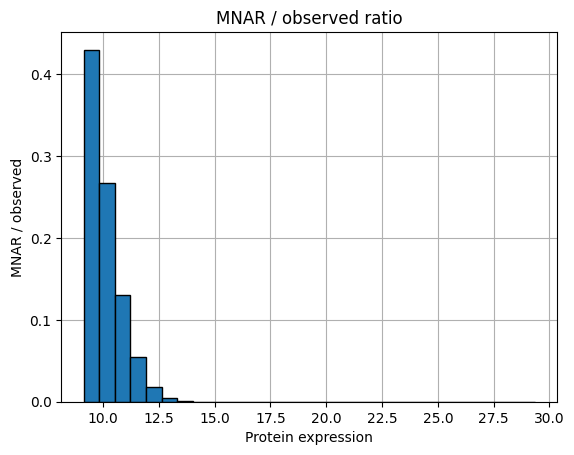

In [7]:
pl.plot_mnar_ratio(adata, m_mnar)

In [8]:
train_mask = ~(m_mcar | m_mnar)

sm.add_train_test_set(adata, train_mask, layer="main")

## PROTVI

### Training

Let's now train the model.

In [9]:
adata.X = adata.layers["train"].copy()
adata.X[np.isnan(adata.X)] = 0

In [10]:
PROTVI.setup_anndata(adata, batch_key="Plate")#, continuous_covariate_keys=["log Qalb"])

model = PROTVI(adata, log_variational=False, decoder_type="selection", max_loss_dropout=0)
#model.view_anndata_setup()

Let's train the model.

In [11]:
model.train(max_epochs=18, plan_kwargs={"mechanism_weight": 1}, check_val_every_n_epoch=1) #, plan_kwargs={"min_kl_weight": 8, "max_kl_weight": 8})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 18/18: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s, v_num=1, train_loss_step=8.39e+3, train_loss_epoch=3.34e+3]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 18/18: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s, v_num=1, train_loss_step=8.39e+3, train_loss_epoch=3.34e+3]


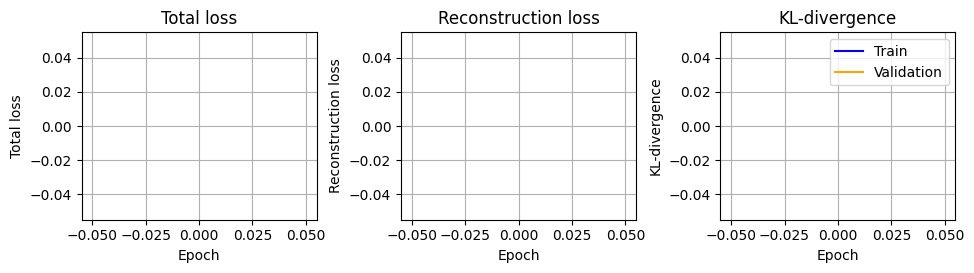

In [12]:
pl.plot_loss(model.history, epoch_start=40, validation_smooth_window=10)

In [13]:
model.save("mai_protvi_baseline_{mnar_proportion}")

### Evaluation on training set (MAIN)

In [14]:
x_est, p_est = model.impute(n_samples=100)

x_main = adata.layers["main"]
x_pilot = adata.layers["pilot"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_main)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_main)] = np.nan

In [15]:
x_test = adata.layers["test"]

x_guess = x_est[~np.isnan(x_test)]
x_true = x_test[~np.isnan(x_test)]

mse_test = metrics.mse(x_guess, x_true)

print(f"Test MSE (individual): {mse_test:.4f}")

Test MSE (individual): 11.2632


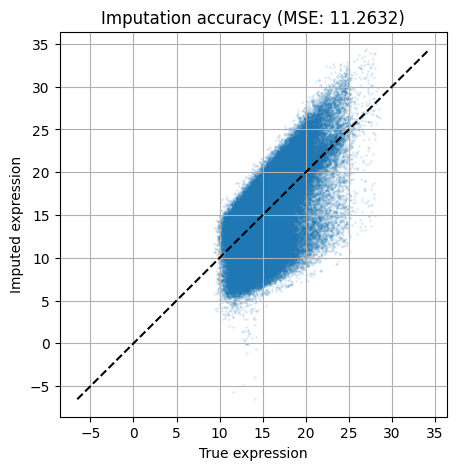

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

v_min = np.min([np.nanmin(x_true), np.nanmin(x_guess)])
v_max = np.max([np.nanmax(x_true), np.nanmax(x_guess)])

ax.plot([v_min, v_max], [v_min, v_max], ls="--", c="black")
ax.scatter(x_true, x_guess, s=1, alpha=0.1)
ax.set_xlabel("True expression")
ax.set_ylabel("Imputed expression")
ax.set_title(f"Imputation accuracy (MSE: {mse_test:.4f})")
ax.grid(True)

In [17]:
x_guess_means = np.nanmean(x_guess, axis=0)
x_true_means = np.nanmean(x_true, axis=0)

mse_test_agg = np.nanmean(x_guess_means - x_true_means)**2

print(f"Test MSE (aggregate): {mse_test_agg:.4f}")

Test MSE (aggregate): 0.0044


In [20]:
res = {
    "model": "baseline",
    "mnar_proportion": mnar_proportion,
    "mse_test": mse_test,
    "mse_test_agg": mse_test_agg
}

PATH = "../../results/manns_lab_data/mai"

sup.save_dict_to_results(res, f"protvi_baseline_{mnar_proportion}2.pkl", PATH)